In [2]:
# Notebook config (run this first cell)
from pathlib import Path
import os, sys

BASE = Path(r"C:\Users\Lenovo\Desktop\LY MAJOR PROJECT")
DATA = BASE / "data"
IMAGES = DATA / "images"
POP = DATA / "population"
ROADS = DATA / "roads"
PROCESSED = DATA / "processed"
OUTPUTS = BASE / "outputs"

for p in [ROADS, POP, PROCESSED, OUTPUTS]:
    p.mkdir(parents=True, exist_ok=True)

print("Base:", BASE)


Base: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT


In [3]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os

roads_fp = ROADS / "pune_roads.shp"
roads = gpd.read_file(roads_fp)
roads.head()


,u,v,key,osmid,highway,oneway,reversed,length,lanes,name,maxspeed,ref,bridge,est_width,access,junction,tunnel,width,geometry
0,245645011,10248250797,0,670151659,residential,False,True,10.313285,None,None,None,None,None,None,None,None,None,None,"LINESTRING (73.89504 18.44157, 73.89506 18.44147)"
1,245645011,10248250791,0,670151659,residential,False,False,34.254289,None,None,None,None,None,None,None,None,None,None,"LINESTRING (73.89504 18.44157, 73.89506 18.441..."
2,245645101,2365711249,0,256448779,trunk,True,False,13.664546,2,Katraj Kondhwa Road,None,None,None,None,None,None,None,None,"LINESTRING (73.85892 18.4472, 73.85879 18.44718)"
3,245645101,2621107676,0,888608969,trunk,False,True,51.983832,2,Katraj Kondhwa Road,None,None,None,None,None,None,None,None,"LINESTRING (73.85892 18.4472, 73.85902 18.4472..."
4,245645101,8006247832,0,"[858863081, 1022821427]",trunk,True,False,115.520877,None,Satara Road,50,NH60,None,None,None,None,None,None,"LINESTRING (73.85892 18.4472, 73.859 18.44686,..."


In [4]:
ref_raster = POP / "ind_pd_2000_1km_UNadj.tif"

with rasterio.open(ref_raster) as src:
    meta = src.meta.copy()
    out_shape = (src.height, src.width)
    transform = src.transform

shapes = ((geom, 1) for geom in roads.geometry)

roads_raster = features.rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# Save rasterized roads
roads_mask_fp = PROCESSED / "roads_mask.tif"

with rasterio.open(roads_mask_fp, 'w', **meta) as dst:
    dst.write(roads_raster, 1)

print("Saved rasterized roads:", roads_mask_fp)


Saved rasterized roads: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT\data\processed\roads_mask.tif


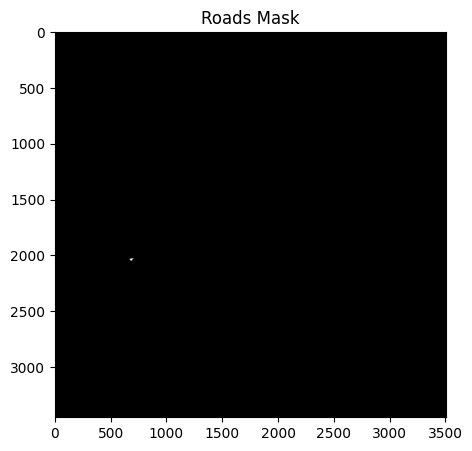

In [5]:
plt.figure(figsize=(12,5))
plt.title("Roads Mask")
plt.imshow(roads_raster, cmap="gray")
plt.show()


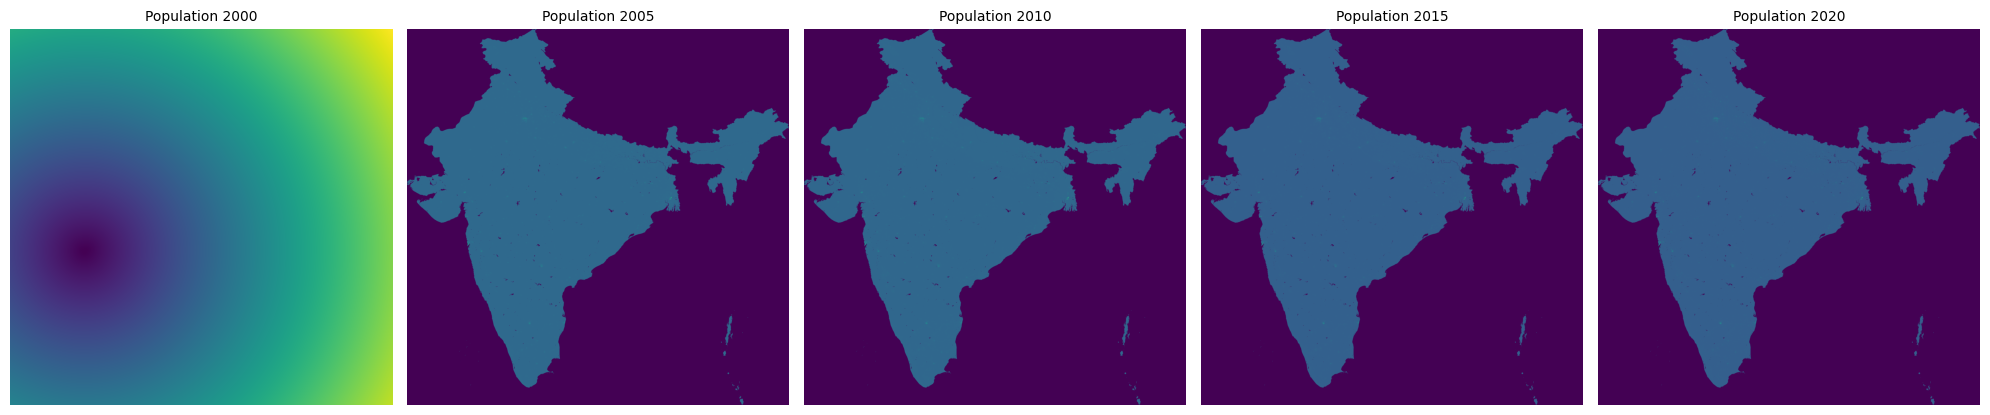

In [6]:
import rasterio
import matplotlib.pyplot as plt

files = [
    POP / "ind_pd_2000_1km_UNadj.tif",
    POP / "ind_pd_2005_1km_UNadj.tif",
    POP / "ind_pd_2010_1km_UNadj.tif",
    POP / "ind_pd_2015_1km_UNadj.tif",
    POP / "ind_pd_2020_1km_UNadj.tif"
]

titles = ["Population 2000", "Population 2005", "Population 2010", "Population 2015", "Population 2020"]

rasters = []
for f in files:
    with rasterio.open(f) as src:
        rasters.append(src.read(1))

plt.figure(figsize=(20, 5))
for i, (data, title) in enumerate(zip(rasters, titles)):
    plt.subplot(1, 5, i+1)
    plt.imshow(data, cmap="viridis")
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
import rasterio
import numpy as np

pop_files = [
    POP / "ind_pd_2000_1km_UNadj.tif",
    POP / "ind_pd_2005_1km_UNadj.tif",
    POP / "ind_pd_2010_1km_UNadj.tif",
    POP / "ind_pd_2015_1km_UNadj.tif",
    POP / "ind_pd_2020_1km_UNadj.tif"
]

population_layers = []
for f in pop_files:
    with rasterio.open(f) as src:
        population_layers.append(src.read(1))

population_stack = np.stack(population_layers, axis=-1)
print("Population stack shape:", population_stack.shape)


Population stack shape: (3451, 3508, 5)


In [8]:
dist_road_path = PROCESSED / "resampled_pop_2000.tif"

with rasterio.open(dist_road_path) as src:
    dist_to_road = src.read(1)

print("Distance-to-road shape:", dist_to_road.shape)


Distance-to-road shape: (7781, 7641)


In [9]:
# Example Landsat bands
red_band = IMAGES / "LC09_L2SP_147047_20250902_20250904_02_T2_SR_B4.TIF"
nir_band = IMAGES / "LC09_L2SP_147047_20250902_20250904_02_T2_SR_B5.TIF"

with rasterio.open(red_band) as red_src, rasterio.open(nir_band) as nir_src:
    red = red_src.read(1).astype("float32")
    nir = nir_src.read(1).astype("float32")

ndvi = (nir - red) / (nir + red + 1e-6)
print("NDVI shape:", ndvi.shape)


NDVI shape: (7781, 7641)


In [10]:
min_shape = (
    min(population_stack.shape[0], dist_to_road.shape[0], ndvi.shape[0]),
    min(population_stack.shape[1], dist_to_road.shape[1], ndvi.shape[1])
)

population_stack = population_stack[:min_shape[0], :min_shape[1], :]
dist_to_road = dist_to_road[:min_shape[0], :min_shape[1]]
ndvi = ndvi[:min_shape[0], :min_shape[1]]

features_stack = np.dstack([population_stack, dist_to_road, ndvi])
print("Final features stack shape:", features_stack.shape)


Final features stack shape: (3451, 3508, 7)


In [11]:
out_path = PROCESSED / "features_stack.npz"
os.makedirs(out_path.parent, exist_ok=True)

np.savez_compressed(out_path, features=features_stack)
print("✅ Saved feature stack at:", out_path)


✅ Saved feature stack at: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT\data\processed\features_stack.npz
